<h1>Import Library</h1>

In [44]:
import re
import pandas as pd
import nltk
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
from nltk.tokenize import RegexpTokenizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd


<h1>Baca Data</h1>

In [45]:
df = pd.read_csv("data.csv")
texts = df["full_text"].astype(str)
texts.to_csv("data.csv", index=False)

In [46]:
topic_keywords = [
    "menkeu", "purbaya", "sri mulyani", "menteri keuangan", "ekonomi",
    "fiskal", "pemerintah", "apbn", "inflasi", "defisit", "utang negara"
]

irrelevant_keywords = [
    "download", "promo", "iklan", "klik link", "aplikasi", "follow", 
    "giveaway", "voucher", "diskon", "gratis", "registrasi", "daftar", "event"
]


def is_relevant(text):
    text_lower = text.lower()
    if any(bad in text_lower for bad in irrelevant_keywords):
        return False
    return any(topic in text_lower for topic in topic_keywords)

mask = df["full_text"].astype(str).apply(is_relevant)
df = df[mask].reset_index(drop=True)

texts = df["full_text"].astype(str)

print(f"Jumlah data setelah pembersihan topik: {len(df)} baris tersisa.")

Jumlah data setelah pembersihan topik: 1379 baris tersisa.


<h1>PraPemrosesan import Stemmer dari Sastrawi</h1>

In [47]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_nltk = set(stopwords.words('indonesian'))
stop_sastrawi = set(StopWordRemoverFactory().get_stop_words())
stop_words = stop_nltk.union(stop_sastrawi)

tokenizer = RegexpTokenizer(r'\w+')

<h1>Pembersihan data menggunakan case folding CPMK 2</h1>

In [48]:
def case_folding(text):
    text = text.lower()
    return text

In [49]:
singkatan_map = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "ngga": "tidak",
    "tdk": "tidak", "tak": "tidak", "t": "tidak", "ndak": "tidak", "enggak": "tidak",
    "yg": "yang", "dgn": "dengan", "dg": "dengan", "krn": "karena", "karen": "karena",
    "utk": "untuk", "biar": "agar", "spy": "supaya", "tp": "tapi", "pdhl": "padahal",
    "sdh": "sudah", "udh": "sudah", "udah": "sudah", "dah": "sudah", "blm": "belum",
    "td": "tidak", "jd": "jadi", "jg": "juga", "dll": "", "dst": "", "dsb": "",
    "gw": "saya", "gue": "saya", "gua": "saya", "sy": "saya", "aq": "saya", "aqh": "saya",
    "aku": "saya", "aqo": "saya", "ane": "saya", "admin": "saya",
    "km": "kamu", "kmu": "kamu", "klo": "kalau", "klu": "kalau", "kalo": "kalau",
    "loe": "kamu", "lu": "kamu", "lo": "kamu", "ente": "kamu", "dirimu": "kamu",
    "dy": "dia", "dya": "dia", "doi": "dia", "dya": "dia", "mrk": "mereka", "tmn": "teman",
    "bgt": "banget", "bgd": "banget", "bnget": "banget", "bngt": "banget", "parahh": "parah",
    "bener": "benar", "bner": "benar", "bneran": "benar", "sumpahh": "sumpah",
    "seriusss": "serius", "seriusan": "serius", "mantul": "mantap betul",
    "btul": "betul", "btl": "betul", "mantep": "mantap", "mantepp": "mantap",
    "skrg": "sekarang", "skr": "sekarang", "td": "tadi", "tadii": "tadi",
    "besok": "besok", "bsok": "besok", "nnti": "nanti", "ntar": "nanti", "lusa": "lusa",
    "dlu": "dulu", "dl": "dulu", "duluu": "dulu", "kmrn": "kemarin", "kmren": "kemarin",
    "trus": "terus", "trs": "terus", "lanjuttt": "lanjut",
    "dr": "dari", "drpd": "daripada", "dpn": "depan", "blkg": "belakang", "sblh": "sebelah",
    "tmpt": "tempat", "rmh": "rumah", "kantor": "kantor", "kntor": "kantor", "sklh": "sekolah",
    "kls": "kelas", "jl": "jalan", "jln": "jalan", "rp": "rupiah", "juta": "juta", "jt": "juta",
    "miliar": "miliar", "milyar": "miliar", "m": "miliar", "t": "triliun", "triliun": "triliun",
    "kmh": "kamar", "kmr": "kamar",
    "wkwk": "", "wk": "", "wkwkwk": "", "haha": "", "hehe": "", "hihi": "", "hoho": "",
    "ckck": "", "btw": "", "lol": "", "xixixi": "", "huhu": "", "ampun": "", "yah": "", "ya": "",
    "lho": "", "loh": "", "dong": "", "deh": "", "sih": "", "lah": "", "nih": "", "tuh": "",
    "kan": "", "kok": "", "cih": "", "astaga": "", "anjir": "", "anjay": "", "anj": "",
    "pls": "tolong", "tolonglah": "tolong", "pliss": "tolong", "plz": "tolong",
    "thx": "terima kasih", "tq": "terima kasih", "makasih": "terima kasih", "mksih": "terima kasih",
    "mksh": "terima kasih", "mks": "terima kasih", "terimakasih": "terima kasih",
    "thanks": "terima kasih", "suwun": "terima kasih",
    "pagi": "selamat pagi", "mlm": "malam", "malem": "malam", "sore": "sore", "siang": "siang",
    "dm": "pesan pribadi", "pm": "pesan pribadi", "fb": "facebook", "ig": "instagram",
    "yt": "youtube", "vid": "video", "vidio": "video", "acc": "akun", "akunmu": "akun kamu",
    "id": "identitas", "link": "tautan", "app": "aplikasi", "web": "situs", "wa": "whatsapp",
    "bbrp": "beberapa", "brp": "berapa", "sm": "sama", "sma": "sama", "ama": "sama",
    "kl": "kalau", "bljr": "belajar", "bljar": "belajar", "sklh": "sekolah",
    "mnt": "menit", "mggu": "minggu", "thn": "tahun", "bln": "bulan",
    "org": "orang", "mslh": "masalah", "krj": "kerja", "pkrjaan": "pekerjaan",
    "prtanyaan": "pertanyaan", "jwbn": "jawaban", "bales": "balas",
    "knp": "kenapa", "kenp": "kenapa", "gmn": "bagaimana", "gmna": "bagaimana", "gimana": "bagaimana",
    "bisaaa": "bisa", "gpp": "tidak apa apa", "gapapa": "tidak apa apa", "gapa": "tidak apa apa",
    "kt": "kota", "da": "daerah", "tmp": "tempat", "trm": "terima", "tkp": "tempat kejadian perkara",
    "jl": "jalan", "jln": "jalan", "rt": "rukun tetangga", "rw": "rukun warga",
    "bucin": "budak cinta", "gabut": "tidak ada kegiatan", "mager": "malas gerak",
    "baper": "bawa perasaan", "ngab": "abang", "bang": "abang", "sis": "kakak",
    "bro": "kakak", "bestie": "teman", "besties": "teman", "crush": "gebetan",
    "gebetan": "orang disukai", "pdkt": "pendekatan", "nembak": "menyatakan cinta",
    "ghosting": "menghilang tiba tiba", "mantan": "bekas pacar",
    "ok": "baik", "oke": "baik", "okey": "baik", "sip": "baik", "siip": "baik", "okayy": "baik"
}


<h1>Preprocessing regex, tokenisasi dan pemakaian stemmer CPMK 3</h1>

In [50]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)     
    text = re.sub(r'@\w+', ' ', text)                
    text = emoji.demojize(text)                      
    text = re.sub(r'\d+', ' ', text)                 
    text = re.sub(r'[^\w\s]', ' ', text)             
    text = re.sub(r'(.)\1{2,}', r'\1', text)         
    text = re.sub(r'\s+', ' ', text).strip()         

    tokens = tokenizer.tokenize(text)

    tokens = [singkatan_map.get(w, w) for w in tokens if w not in singkatan_map or singkatan_map[w] != ""]

    tokens = [w for w in tokens if w not in stop_words]

    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

df["preprocessing"] = texts.apply(clean_text)


In [51]:
df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding CPMK2": texts.apply(case_folding),
    "preprocessing CPMK3": df["preprocessing"]
})

df_new.to_csv("data.csv", index=False)

<h1>CPMK4 N-Gram</h1>

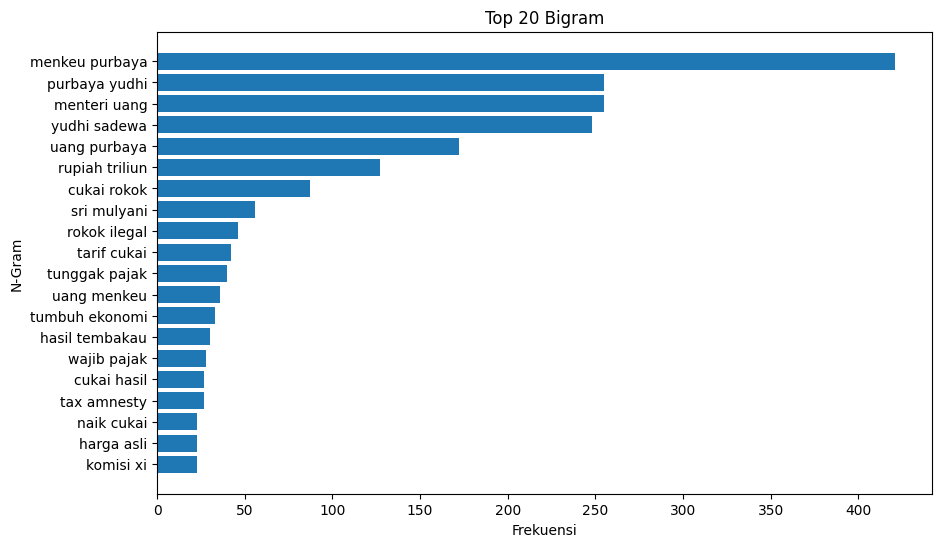

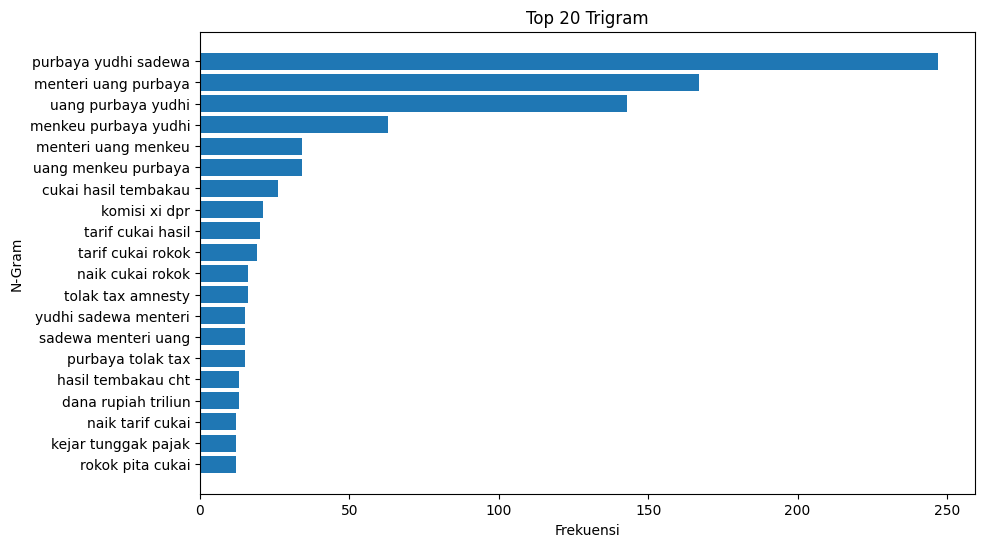

In [52]:
corpus = df_new["preprocessing CPMK3"].astype(str)

def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=20, title="Top N-Grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    ngram_df = pd.DataFrame(words_freq, columns=['NGram', 'Count'])

    plt.figure(figsize=(10,6))
    plt.barh(ngram_df['NGram'][::-1], ngram_df['Count'][::-1])
    plt.title(title)
    plt.xlabel("Frekuensi")
    plt.ylabel("N-Gram")
    plt.show()

plot_top_ngrams(corpus, ngram_range=(2, 2), title="Top 20 Bigram")
plot_top_ngrams(corpus, ngram_range=(3, 3), title="Top 20 Trigram")


<h1>CPMK4 WordCloud</h1>

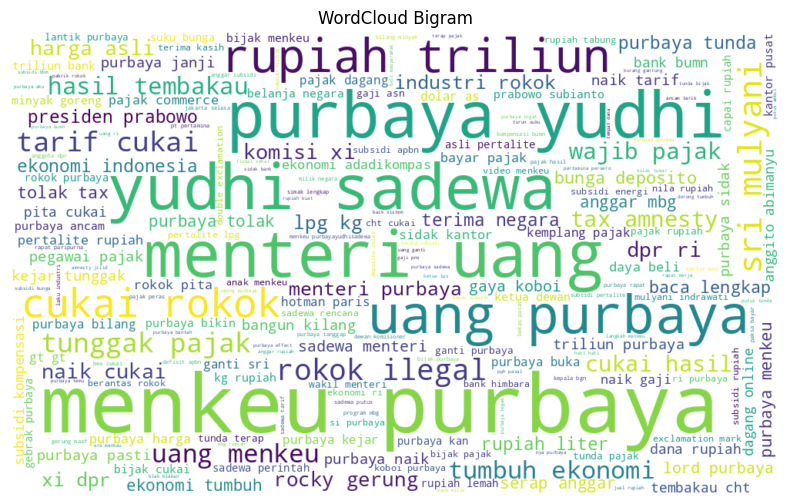

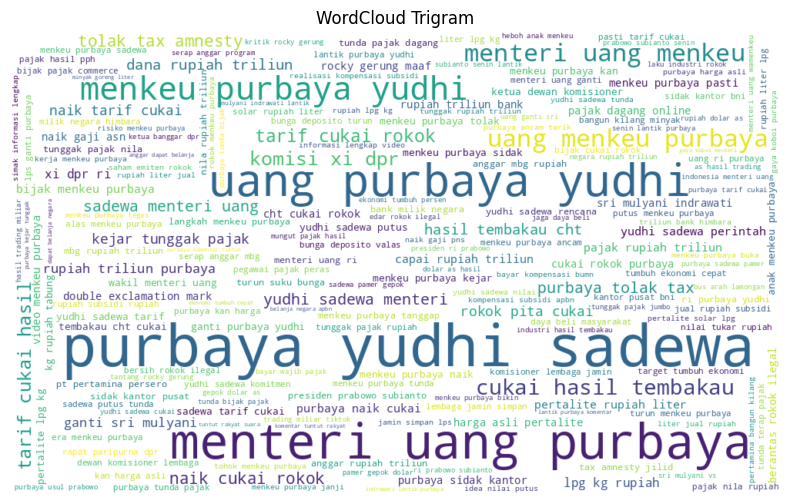

In [53]:
def generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    freq_dict = dict(words_freq)
    
    plt.figure(figsize=(10,6))
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram")
generate_ngram_wordcloud(corpus, ngram_range=(3,3), title="WordCloud Trigram")


<h1>Pemanggilan inset_lexicon.json sebagai labeling data (data dilabeling auto)</h1>

In [35]:
with open("inset_lexicon.json", "r", encoding="utf-8") as f:
    inset_lex = json.load(f)

pos_dict = inset_lex.get("positive", {})
neg_dict = inset_lex.get("negative", {})

def label_with_inset(text):
    score = 0.0
    for w in text.split():
        if w in pos_dict:
            score += pos_dict[w]
        elif w in neg_dict:
            score += neg_dict[w]
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["clean_text"].apply(label_with_inset)
print("Distribusi Sentimen (dengan InSet):\n", df["sentiment"].value_counts())


Distribusi Sentimen (dengan InSet):
 sentiment
positive    875
negative    479
neutral     164
Name: count, dtype: int64


<h1>Pembobotan TF-IDF</h1>

In [36]:
X = df["clean_text"]
y = df["sentiment"]

vectorizer = TfidfVectorizer(
    max_features=2000,   
    ngram_range=(1,2),   
    sublinear_tf=True,
    min_df=2              
)
X_tfidf = vectorizer.fit_transform(df["clean_text"])

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

<h1>Modelling dengan tuning GridSearch</h1>

In [37]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto", 0.01, 0.1, 1],
    "degree": [2, 3, 4], 
    "class_weight": [None, "balanced"]
}


grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring="f1_macro",  
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (F1-macro):", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Classification Report (Best SVM):\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score (F1-macro): 0.6016012025913317
Classification Report (Best SVM):
               precision    recall  f1-score   support

    negative       0.73      0.61      0.67        96
     neutral       0.75      0.27      0.40        33
    positive       0.74      0.89      0.81       175

    accuracy                           0.74       304
   macro avg       0.74      0.59      0.62       304
weighted avg       0.74      0.74      0.72       304



<h1>Evaluasi</h1>

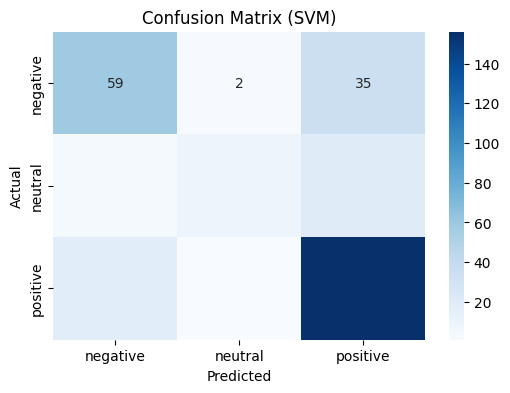

In [38]:
cm = confusion_matrix(y_test, y_pred, labels=best_svm.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_svm.classes_,
            yticklabels=best_svm.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.show()


<h1>Visualisasi</h1>

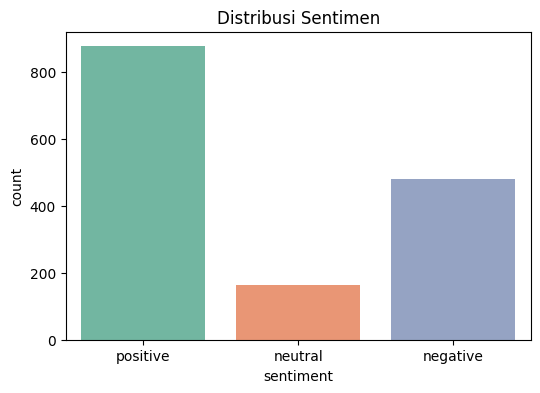

In [39]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=df,
              order=["positive","neutral","negative"],
              palette="Set2")
plt.title("Distribusi Sentimen")
plt.show()
